In [1]:
import pandas as pd 
import numpy 
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
pd_df = pd.read_csv('datasets/titanic.csv')
pd_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
spark = SparkSession.builder.appName('TitanicApp').getOrCreate()

22/04/16 21:52:20 WARN Utils: Your hostname, zoirasu resolves to a loopback address: 127.0.1.1; using 192.168.1.37 instead (on interface wlp0s20f3)
22/04/16 21:52:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/16 21:52:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
spark

In [6]:
dfspark = spark.read.csv('datasets/titanic.csv',header=True,inferSchema=True)

In [7]:
dfspark.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
dfspark.first()

Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S')

In [9]:
df2 = dfspark.drop('PassengerId','Name','Ticket')

In [10]:
df2.first()

Row(Survived=0, Pclass=3, Sex='male', Age=22.0, SibSp=1, Parch=0, Fare=7.25, Cabin=None, Embarked='S')

In [11]:
df2.columns

['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked']

In [12]:
dfspark.describe(['Survived','Pclass']).show()

+-------+-------------------+------------------+
|summary|           Survived|            Pclass|
+-------+-------------------+------------------+
|  count|                891|               891|
|   mean| 0.3838383838383838| 2.308641975308642|
| stddev|0.48659245426485753|0.8360712409770491|
|    min|                  0|                 1|
|    max|                  1|                 3|
+-------+-------------------+------------------+



In [13]:
def sparkShape(datasparkFrame):
    return (datasparkFrame.count(),len(datasparkFrame.columns))

In [14]:
sparkShape(df2)

(891, 9)

In [15]:
# Find Missing Values Extended
def findSparkDfMissingVals(sparkDataFrame):
    missings = sparkDataFrame.select([F.count(F.when( F.col(c).isNull() | F.col(c).contains('None') | F.col(c).contains('NULL') | (F.col(c) == '') | F.isnan(c) | F.isnull(c)
   ,c)).alias(c) for c in sparkDataFrame.columns])
    return missings.collect()

missing_vals = findSparkDfMissingVals(df2)
missing_vals

[Row(Survived=0, Pclass=0, Sex=0, Age=177, SibSp=0, Parch=0, Fare=0, Cabin=687, Embarked=2)]

In [16]:
df2 = df2.drop('Cabin')
df2.columns

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [17]:
from pyspark.ml.feature import Imputer

In [18]:
mean_imputer = Imputer(inputCol='Age',outputCol='Age_updated',strategy='mean')
model = mean_imputer.fit(df2)
dfupdated = model.transform(df2)

In [19]:
dfupdated.head(5)

[Row(Survived=0, Pclass=3, Sex='male', Age=22.0, SibSp=1, Parch=0, Fare=7.25, Embarked='S', Age_updated=22.0),
 Row(Survived=1, Pclass=1, Sex='female', Age=38.0, SibSp=1, Parch=0, Fare=71.2833, Embarked='C', Age_updated=38.0),
 Row(Survived=1, Pclass=3, Sex='female', Age=26.0, SibSp=0, Parch=0, Fare=7.925, Embarked='S', Age_updated=26.0),
 Row(Survived=1, Pclass=1, Sex='female', Age=35.0, SibSp=1, Parch=0, Fare=53.1, Embarked='S', Age_updated=35.0),
 Row(Survived=0, Pclass=3, Sex='male', Age=35.0, SibSp=0, Parch=0, Fare=8.05, Embarked='S', Age_updated=35.0)]

In [20]:
dfupdated.show()

+--------+------+------+----+-----+-----+-------+--------+-----------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|      Age_updated|
+--------+------+------+----+-----+-----+-------+--------+-----------------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|             22.0|
|       1|     1|female|38.0|    1|    0|71.2833|       C|             38.0|
|       1|     3|female|26.0|    0|    0|  7.925|       S|             26.0|
|       1|     1|female|35.0|    1|    0|   53.1|       S|             35.0|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|             35.0|
|       0|     3|  male|null|    0|    0| 8.4583|       Q|29.69911764705882|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|             54.0|
|       0|     3|  male| 2.0|    3|    1| 21.075|       S|              2.0|
|       1|     3|female|27.0|    0|    2|11.1333|       S|             27.0|
|       1|     2|female|14.0|    1|    0|30.0708|       C|             14.0|

In [21]:
df3 = dfupdated.drop('Embarked')

In [22]:
df3.columns

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_updated']

In [23]:
df4 = df3.select(df3.columns[:3] + df3.columns[4:])

In [24]:
df4.show()

+--------+------+------+-----+-----+-------+-----------------+
|Survived|Pclass|   Sex|SibSp|Parch|   Fare|      Age_updated|
+--------+------+------+-----+-----+-------+-----------------+
|       0|     3|  male|    1|    0|   7.25|             22.0|
|       1|     1|female|    1|    0|71.2833|             38.0|
|       1|     3|female|    0|    0|  7.925|             26.0|
|       1|     1|female|    1|    0|   53.1|             35.0|
|       0|     3|  male|    0|    0|   8.05|             35.0|
|       0|     3|  male|    0|    0| 8.4583|29.69911764705882|
|       0|     1|  male|    0|    0|51.8625|             54.0|
|       0|     3|  male|    3|    1| 21.075|              2.0|
|       1|     3|female|    0|    2|11.1333|             27.0|
|       1|     2|female|    1|    0|30.0708|             14.0|
|       1|     3|female|    1|    1|   16.7|              4.0|
|       1|     1|female|    0|    0|  26.55|             58.0|
|       0|     3|  male|    0|    0|   8.05|           

In [25]:
df4 = df4.withColumnRenamed('Age_updated','Age')

In [26]:
df4.show()

+--------+------+------+-----+-----+-------+-----------------+
|Survived|Pclass|   Sex|SibSp|Parch|   Fare|              Age|
+--------+------+------+-----+-----+-------+-----------------+
|       0|     3|  male|    1|    0|   7.25|             22.0|
|       1|     1|female|    1|    0|71.2833|             38.0|
|       1|     3|female|    0|    0|  7.925|             26.0|
|       1|     1|female|    1|    0|   53.1|             35.0|
|       0|     3|  male|    0|    0|   8.05|             35.0|
|       0|     3|  male|    0|    0| 8.4583|29.69911764705882|
|       0|     1|  male|    0|    0|51.8625|             54.0|
|       0|     3|  male|    3|    1| 21.075|              2.0|
|       1|     3|female|    0|    2|11.1333|             27.0|
|       1|     2|female|    1|    0|30.0708|             14.0|
|       1|     3|female|    1|    1|   16.7|              4.0|
|       1|     1|female|    0|    0|  26.55|             58.0|
|       0|     3|  male|    0|    0|   8.05|           

In [27]:
findSparkDfMissingVals(df4)

[Row(Survived=0, Pclass=0, Sex=0, SibSp=0, Parch=0, Fare=0, Age=0)]

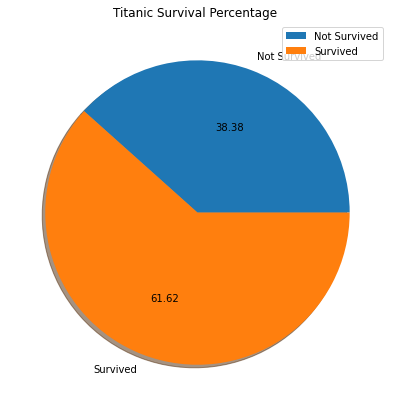


Question-4 -> Plot pie chart which shows the percentage of passengers are survived or not.
Plot saved your local disk as  pie_titanic_survival_percentage.png

Solution as numeric
0 : Not Survived
1 : Survived
	 Counts of Survivals
Not Survived  :  342
Survived  :  549


In [28]:
#Q4 - Plot pie chart which shows the percentage of passengers survived / not.
#Q4 - Plot pie chart which shows the percentage of passengers survived / not.
surviving_values = df4.select('Survived').groupBy('Survived').count()
surviving_values.collect()[0].asDict()


surviving_cases = df4.select('Survived').groupBy('Survived').count().collect()
surviving_values = [surviving_cases[0]['count'],surviving_cases[1]['count']] 
surviving_values_dict = {'Not Survived':surviving_values[0],'Survived':surviving_values[1]}
surviving_values_dict


plt.figure(figsize=(7,7))
plt.pie(surviving_values,labels=surviving_values_dict,autopct='%.2f',shadow=True)
plt.legend(surviving_values_dict,loc='best')
plt.title('Titanic Survival Percentage ')
plt_name = 'pie_titanic_survival_percentage.png'
plt.savefig(plt_name)
plt.show()
print("\nQuestion-4 -> Plot pie chart which shows the percentage of passengers are survived or not.")
print("Plot saved your local disk as ", plt_name)
print("\nSolution as numeric")
print("0 : Not Survived\n1 : Survived\n\t Counts of Survivals")
for k,v in surviving_values_dict.items():
  print(k," : ",v)

In [29]:
data = df4.select('Sex').groupBy('Sex').count().collect()
print("DCT:",data)


DCT: [Row(Sex='female', count=314), Row(Sex='male', count=577)]


In [30]:
labels = [row['Sex'] for row in data]
label_counts = [row['count'] for row in data]

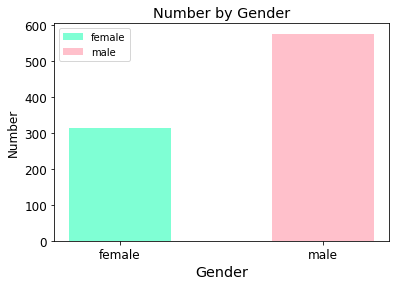


Question-5 -> Plot bar chart which shows number of female passengers and total male passengers.
Plot saved your local disk as  bar_Number_of_passengers_by_gender.png

Solution as numeric
 [Row(Sex='female', count=314), Row(Sex='male', count=577)]


In [33]:
plt.bar(labels[0],height=label_counts[0],width=0.5,color='aquamarine')
plt.bar(labels[1],height=label_counts[1],width=0.5,color='pink')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.xlabel("Gender",fontsize='x-large')
plt.ylabel("Number",fontsize='large')
plt.title("Number by Gender",fontsize='x-large')
plt.legend(labels,loc='best',labelspacing=0.5)
plt_name ='bar_Number_of_passengers_by_gender.png'
plt.savefig(plt_name)
plt.show()
print("\nQuestion-5 -> Plot bar chart which shows number of female passengers and total male passengers.")
print("Plot saved your local disk as ", plt_name)
print("\nSolution as numeric\n",data)

In [35]:
from pyspark.ml.feature import VectorAssembler,StringIndexer

In [36]:
df4.first()

Row(Survived=0, Pclass=3, Sex='male', SibSp=1, Parch=0, Fare=7.25, Age=22.0)

In [37]:
si_model = StringIndexer(inputCol='Sex',outputCol='Sex_indexed').fit(df4)
df5 = si_model.transform(df4).drop('Sex').withColumnRenamed('Sex_indexed','Sex')
df5.first()

Row(Survived=0, Pclass=3, SibSp=1, Parch=0, Fare=7.25, Age=22.0, Sex=0.0)

In [38]:
va = VectorAssembler(inputCols=['Pclass','Sex','SibSp','Parch','Fare','Age'],outputCol='features')
df6 = va.transform(df5)

In [39]:
df6.show()

+--------+------+-----+-----+-------+-----------------+---+--------------------+
|Survived|Pclass|SibSp|Parch|   Fare|              Age|Sex|            features|
+--------+------+-----+-----+-------+-----------------+---+--------------------+
|       0|     3|    1|    0|   7.25|             22.0|0.0|[3.0,0.0,1.0,0.0,...|
|       1|     1|    1|    0|71.2833|             38.0|1.0|[1.0,1.0,1.0,0.0,...|
|       1|     3|    0|    0|  7.925|             26.0|1.0|[3.0,1.0,0.0,0.0,...|
|       1|     1|    1|    0|   53.1|             35.0|1.0|[1.0,1.0,1.0,0.0,...|
|       0|     3|    0|    0|   8.05|             35.0|0.0|[3.0,0.0,0.0,0.0,...|
|       0|     3|    0|    0| 8.4583|29.69911764705882|0.0|[3.0,0.0,0.0,0.0,...|
|       0|     1|    0|    0|51.8625|             54.0|0.0|[1.0,0.0,0.0,0.0,...|
|       0|     3|    3|    1| 21.075|              2.0|0.0|[3.0,0.0,3.0,1.0,...|
|       1|     3|    0|    2|11.1333|             27.0|1.0|[3.0,1.0,0.0,2.0,...|
|       1|     2|    1|    0

In [40]:
df7 = df6.select('features','Survived')
df7.show()

+--------------------+--------+
|            features|Survived|
+--------------------+--------+
|[3.0,0.0,1.0,0.0,...|       0|
|[1.0,1.0,1.0,0.0,...|       1|
|[3.0,1.0,0.0,0.0,...|       1|
|[1.0,1.0,1.0,0.0,...|       1|
|[3.0,0.0,0.0,0.0,...|       0|
|[3.0,0.0,0.0,0.0,...|       0|
|[1.0,0.0,0.0,0.0,...|       0|
|[3.0,0.0,3.0,1.0,...|       0|
|[3.0,1.0,0.0,2.0,...|       1|
|[2.0,1.0,1.0,0.0,...|       1|
|[3.0,1.0,1.0,1.0,...|       1|
|[1.0,1.0,0.0,0.0,...|       1|
|[3.0,0.0,0.0,0.0,...|       0|
|[3.0,0.0,1.0,5.0,...|       0|
|[3.0,1.0,0.0,0.0,...|       0|
|[2.0,1.0,0.0,0.0,...|       1|
|[3.0,0.0,4.0,1.0,...|       0|
|[2.0,0.0,0.0,0.0,...|       1|
|[3.0,1.0,1.0,0.0,...|       0|
|[3.0,1.0,0.0,0.0,...|       1|
+--------------------+--------+
only showing top 20 rows



In [41]:
df7.first()

Row(features=DenseVector([3.0, 0.0, 1.0, 0.0, 7.25, 22.0]), Survived=0)

In [42]:
train_data,test_data = df7.randomSplit([0.8,0.2])

In [43]:
train_data.first()

Row(features=SparseVector(6, {0: 1.0, 5: 29.6991}), Survived=0)

In [44]:
from pyspark.ml.classification import LogisticRegression

logreg = LogisticRegression(featuresCol='features',labelCol='Survived')
model = logreg.fit(train_data)

22/04/16 21:53:39 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/16 21:53:39 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [45]:
model.coefficients,model.intercept

(DenseVector([-1.022, 2.7667, -0.4191, -0.1614, 0.0045, -0.0416]),
 2.1082464796581375)

In [46]:
evaluation = model.evaluate(test_data)

In [47]:
evaluation.accuracy,evaluation.areaUnderROC

(0.8023255813953488, 0.862389193752638)

In [48]:
preds = model.transform(test_data)

In [49]:
preds.show()

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(6,[0,5],[1.0,29....|       0|[0.15025684283989...|[0.53749369560443...|       0.0|
|(6,[0,5],[3.0,36.0])|       0|[2.45667500145732...|[0.92104821249550...|       0.0|
|(6,[0,5],[3.0,49.0])|       0|[2.99790066961368...|[0.95247919592868...|       0.0|
|[1.0,0.0,0.0,0.0,...|       0|[0.03452714298893...|[0.50863092833648...|       0.0|
|[1.0,0.0,0.0,0.0,...|       1|[0.29557045968828...|[0.57335932345777...|       0.0|
|[1.0,0.0,0.0,0.0,...|       0|[1.37685337114673...|[0.79848516238600...|       0.0|
|[1.0,0.0,0.0,0.0,...|       1|[-0.0978746705977...|[0.47555084669097...|       1.0|
|[1.0,0.0,0.0,0.0,...|       1|[0.01449700263011...|[0.50362418718522...|       0.0|
|[1.0,0.0,0.0,0.0,...|       0|[1.30953397544625...|[0.7874351626

In [50]:
# Sample Alma
sample = preds.collect()[20]
sdct = sample.asDict()
df10 = spark.createDataFrame([sdct])
df10.show()

+--------+--------------------+----------+--------------------+--------------------+
|Survived|            features|prediction|         probability|       rawPrediction|
+--------+--------------------+----------+--------------------+--------------------+
|       1|[1.0,0.0,1.0,0.0,...|       0.0|[0.72636259000507...|[0.97624541657823...|
+--------+--------------------+----------+--------------------+--------------------+

